# VPN User Usage Analytics

In this notebook we are getting data from our mongodb.

Data that saved in mongodb is by the script named `get_data` that runs every 1 hour.

In [49]:
# Database
from pymongo import MongoClient as mongo

# Data proccessing
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Make HTTP requests
import requests as req

# Color
import seaborn as sb

# Date and time
import datetime

# Config
from config.config import env

In [27]:
# Create mongo connection
client = mongo(env('MONGO_ATLAS'))

db = client["vpn"] # Use database
collection = db['stats'] # Use collection

In [28]:
# Make list
items = []

# Get user_id
uid = int(input("User ID: "))

# Find records
d = collection.find({'id': uid})

# Append records in list
for document in d:
    items.append(document)
    
# Create dataframe
df = pd.DataFrame(items)

# Diff
df['upload'] = df['upload'].diff().fillna(0) # Get diff of upload
df['download'] = df['download'].diff().fillna(0) # Get diff of download

# Show dataframe
df

User ID: 1


,_id,remark,download,upload,id,sequence
0,6470bad7e33ee09af68b7778,Amirhossein Mohammadi,0.0,0.0,1,1.685109e+09
1,6470de346e52dfb8ab929ec8,Amirhossein Mohammadi,33139601.0,2823378.0,1,1.685119e+09


## Line chart

The usage of user based on collected data every hour.

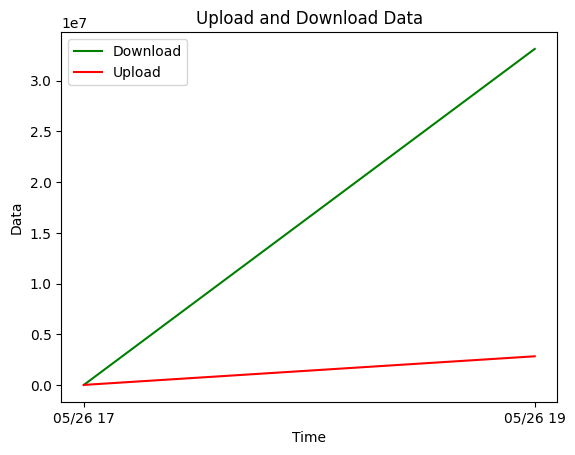

In [62]:
# Convert timestamp to readable
sequences = [datetime.datetime.fromtimestamp(item).strftime("%m/%d %H") for item in df.sequence]

# Draw lines
plt.plot(sequences, df.download, color='green', label='Download') # Draw download line
plt.plot(sequences, df.upload, color='red', label='Upload') # Draw upload line

# Customize plot
plt.title('Upload and Download Data') # Add title
plt.xlabel('Time') # Give label to x
plt.ylabel('Data') # Give label to y
plt.legend() # Add helper

# Show plot
plt.show()

## Pie chart

Pie plot with uploads and downloads data.

In [23]:
# The base URL
base_url = "http://95.216.138.218:2003"

# Add headers to authorize in API
headers = {
    "Cookie": env('COOCIE')
}

# Get list of 
list = req.post(f"{base_url}/xui/inbound/list", headers=headers, data={})
    
# Make json and get only `obj` item
data = [item for item in list.json()["obj"] if item['id'] == uid][0]

In [24]:
pie_sized = [data['down'], data['up']]
pie_label = ['Download', 'Upload']

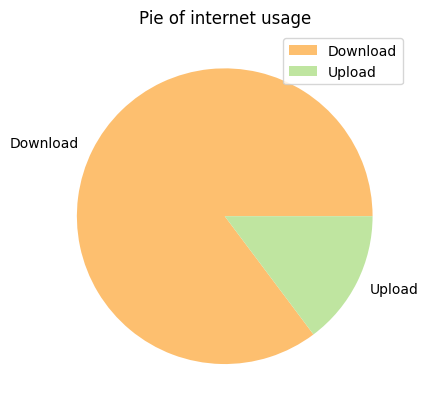

In [25]:
# Draw plt
plt.pie(
    pie_sized,
    labels=pie_label,
    colors=sb.color_palette("Spectral", len(pie_sized))
)

# Customize
plt.title('Pie of internet usage') # Title
plt.legend() # Helper

# Show plt
plt.show()